# Self Driving Car Nanodegree - Project 3 Behavioral Cloning

In this project, I design a convolutional neural network to learn how to drive on a udacity simulation track and then test out how it performs on a different track which the model had not seen during training. The first part of the project focuses on learning the steering angles based on the data provided by udacity

In [1]:
import pandas as pd
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.core import Lambda
from keras.utils import np_utils
from keras.preprocessing import image
from keras.optimizers import Adam
from keras import backend as K
from keras.applications import VGG16
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.
/root/miniconda3/envs/carnd_term_1/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/root/miniconda3/envs/carnd_term_1/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data exploration

In [2]:
data_directory = 'data/'
simulation_data = pd.read_csv(data_directory+ 'driving_log.csv')
simulation_data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
simulation_data.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


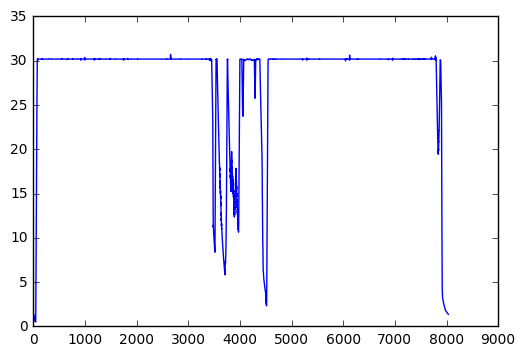

In [4]:
plt.plot(simulation_data['speed'])

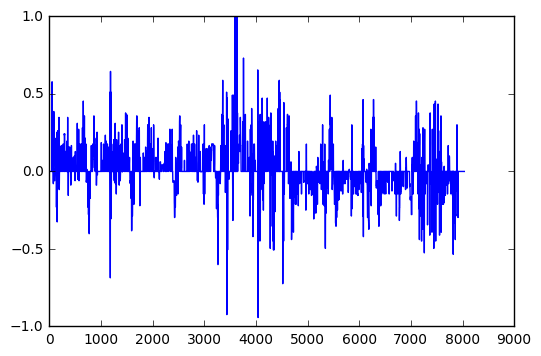

In [5]:
plt.plot(simulation_data['steering'])

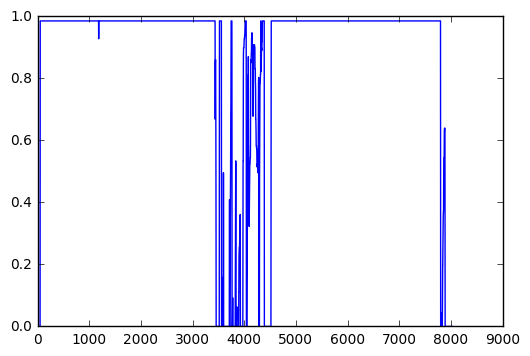

In [6]:
plt.plot(simulation_data['throttle'])

From the dataset collected we find that there is a lot of variation in the steering angles of the car and the values lie between -1 and 1. at the same time we find that the speed and throttle of the car seems to remain fairly constant except for the part of the graph where the the steering angles vary alot. our aim should be to mimic the steering behaviour as expressed by the graph. we can use that as a reliable guide to tell if the network is learning or not.

## image exploration

In [7]:
no_turn = simulation_data[simulation_data['steering'] == 0.0 ].iloc[0]
left_turn = simulation_data[(simulation_data['steering'] >= 0.6) & (simulation_data['steering'] <= 1.0) ].iloc[0]
right_turn = simulation_data[(simulation_data['steering'] >= -1) & (simulation_data['steering'] <= -0.6) ].iloc[0]

In [8]:
def plot_images_from_row(row, image_preprocess=lambda x: x):
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
    image = plt.imread(data_directory+ row['left'].strip())
    ax1.imshow(image_preprocess(image))
    ax1.grid(False)
    
    image = plt.imread(data_directory+ row['center'])
    ax2.imshow(image_preprocess(image))
    ax2.grid(False)
    image = plt.imread(data_directory+ row['right'].strip())
    ax3.imshow(image_preprocess(image))
    ax3.grid(False)

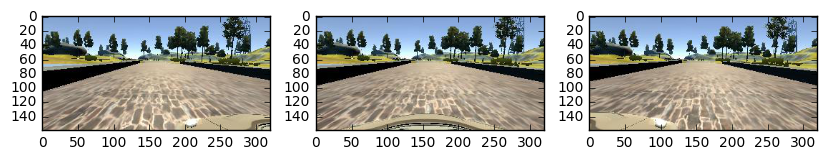

In [9]:
plot_images_from_row(no_turn)

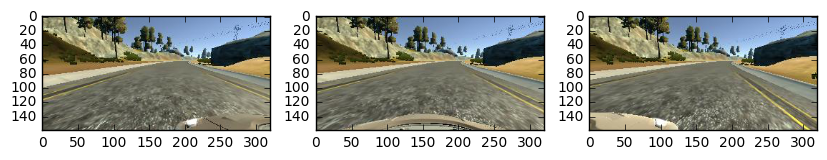

In [10]:
plot_images_from_row(left_turn)

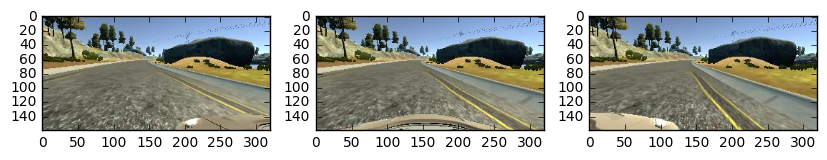

In [11]:
plot_images_from_row(right_turn)

from the initial observation of the images we see that the bottom part of the images contain the image of the car, i chose to crop the image so that the images can be used for data augmentation to create recovery scenarios for the car

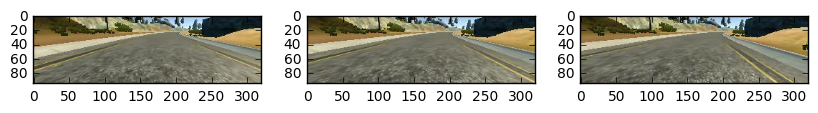

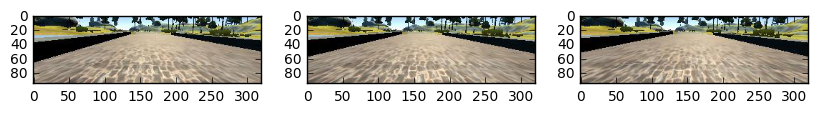

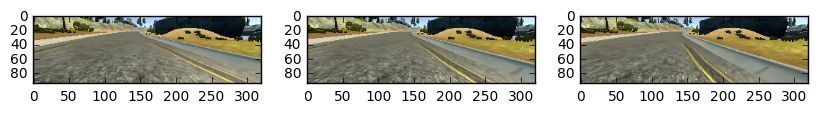

In [12]:
def crop_image(image, top=40, bottom=135):
    return image[top:bottom]

plot_images_from_row(left_turn, crop_image)
plot_images_from_row(no_turn, crop_image)
plot_images_from_row(right_turn, crop_image)

Let's also observe the images in different color spaces to see if a different representation helps segment the features more obvious

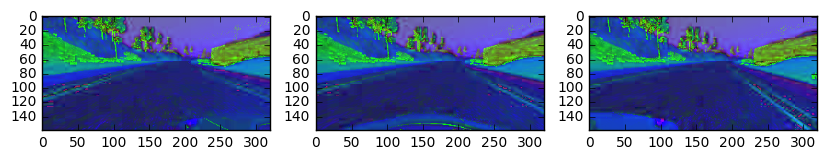

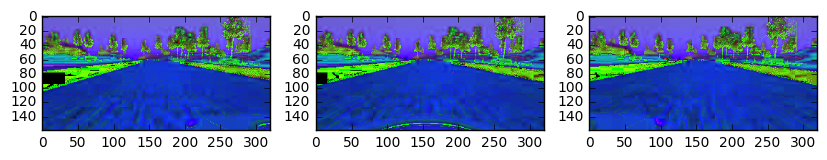

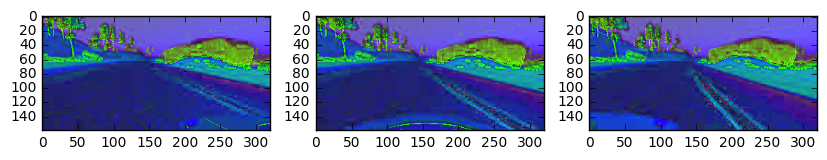

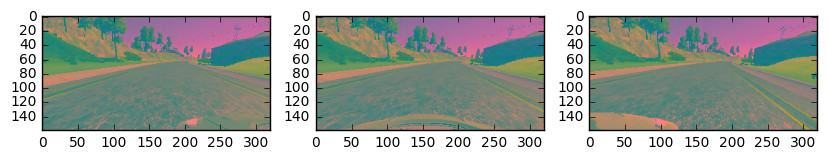

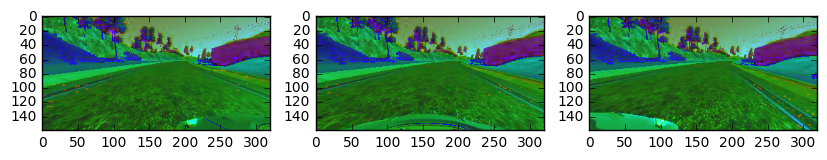

In [13]:
def convert_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
plot_images_from_row(left_turn, convert_to_hsv)
plot_images_from_row(no_turn, convert_to_hsv)
plot_images_from_row(right_turn, convert_to_hsv)
def convert_to_yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_images_from_row(left_turn, convert_to_yuv)

def convert_to_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
plot_images_from_row(left_turn, convert_to_hls)

## Data Augmentation
In this section I explore some methods to augment the precollected data to improve the generalization capabilities of the models.
The ideas explored include :
 * turn angle adjustments using the left / right camera images
 * brightness adjustments
 * translations on y axis to create impression of uphill and downhill movement


In [27]:
def preprocess_function(image):
    return cv2.resize(image, (106, 53))

def load_image(src, preprocess_function=preprocess_function):
    image = plt.imread(src)
    return preprocess_function(image)

all_images = []
for img_src in tqdm(simulation_data['center']):
    all_images.append(load_image(data_directory+img_src.strip()))

for img_src in tqdm(simulation_data['left']):
    all_images.append(load_image(data_directory+img_src.strip()))

for img_src in tqdm(simulation_data['right']):
    all_images.append(load_image(data_directory+img_src.strip()))


100%|██████████| 8036/8036 [01:22<00:00, 97.93it/s] 


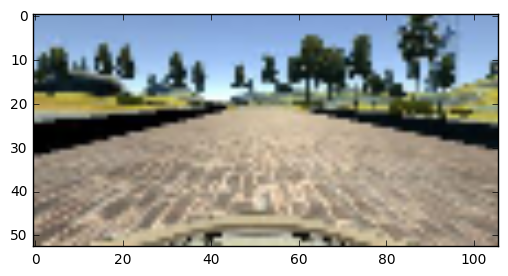

In [28]:
plt.imshow(all_images[0])

In [29]:
steering_angles = simulation_data['steering']
steering_left = steering_angles.copy().apply(lambda x: min(1, x+0.25))
steering_right = steering_angles.copy().apply(lambda x: max(-1, x-0.25))
steering_angles = steering_angles.append(steering_left)
steering_angles = steering_angles.append(steering_right)


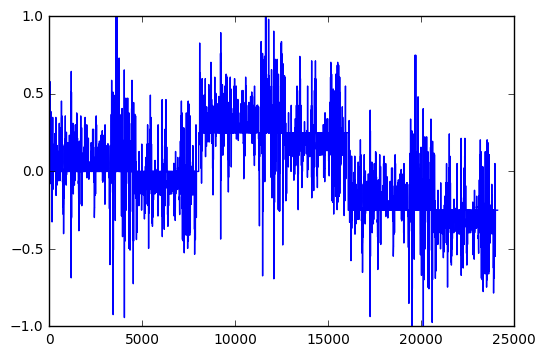

In [30]:
plt.plot(steering_angles.values)

We split the steering angle augmented dataset into the training and validation sets, the brightness augmentation and the y translations are done using the keras dataset fit generator.

In [31]:
X_train, X_test, y_train , y_test = train_test_split(all_images, steering_angles, test_size=0.1)

I also horizontally flip all the data and reverse the corresponding steering angles. 

In [32]:
X_train = np.asarray(X_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)
X_train = np.append(X_train,X_train[:,:,::-1],axis=0)
y_train = np.append(y_train,-y_train,axis=0)

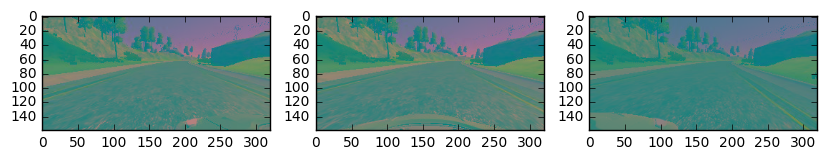

In [33]:
def augment_brightness_and_yuv(image):
    change_pct = np.random.uniform(0.4, 1.2)
    
    # Change to HSV to change the brightness V
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * change_pct
    
    #Convert back to RGB 
    img_brightness = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return convert_to_yuv(img_brightness)

plot_images_from_row(left_turn, augment_brightness_and_yuv)

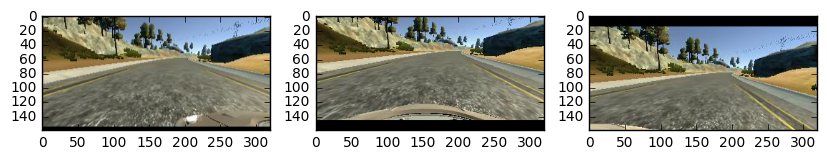

In [34]:
def translate_image_random(image):
    y_translate = np.random.uniform(-40, 40)
    rows, cols, channel = image.shape
    M = np.float32([[1,0,0],[0,1,y_translate]])
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

plot_images_from_row(left_turn, translate_image_random)

In [35]:
train_datagen = image.ImageDataGenerator(
    preprocessing_function=augment_brightness_and_yuv,
)
test_datagen = image.ImageDataGenerator()

In [37]:
X_train.shape

(43394, 53, 106, 3)

## Machine learning models
since the values of the steering angles are continuous valus between -1 and +1 we know that predicting the angle is essentially a regression task. a working solution to this problem was published by Nvidia in the paper (End to End Learning for Self-Driving Cars) https://arxiv.org/abs/1604.07316. I experiment by comparing the nvidia model along with a transfer learning from VGG16.

#### 1. Nvidia End to End Learning model


In [26]:
nvidia_model = Sequential([
        Lambda(lambda x: (x/ 127.5 - 1.),input_shape=(53,106,3)),
        Convolution2D(24, 5 , 5, border_mode='valid', activation='relu'),
        Convolution2D(36, 5 , 5, border_mode='valid', activation='relu'),
        Convolution2D(48, 5 , 5, border_mode='valid', activation='relu'),
        Convolution2D(64, 3 , 3, border_mode='valid', activation='relu'),
        Convolution2D(64, 3 , 3, border_mode='valid', activation='relu'),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(100, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1, activation='tanh'),
    ])
nvidia_model.compile(optimizer=Adam(), loss='mse')
nvidia_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 53, 106, 3)    0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 49, 102, 24)   1824        lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 45, 98, 36)    21636       convolution2d_16[0][0]           
____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 41, 94, 48)    43248       convolution2d_17[0][0]           
___________________________________________________________________________________________

#### 2.  VGG16 feature transfer

In [38]:
vgg_features = VGG16(include_top=False, input_shape=(53, 106, 3), weights='imagenet')
vgg_model = Sequential([
        Lambda(lambda x: (x/ 127.5 - 1.),input_shape=(53,106,3)),
    ])
vgg_model.add(vgg_features)
for l in vgg_model.layers:
    l.trainable = False
vgg_model.add(Flatten())
vgg_model.add(Dense(100, activation='relu'))
vgg_model.add(Dense(10, activation='relu'))
vgg_model.add(Dense(1, activation='tanh'))
vgg_model.compile(loss='mse', optimizer=Adam())
vgg_model.summary()

 6373376/58889256 [==>...........................] - ETA: 606s

KeyboardInterrupt: 

I trained both models using the training datasets and evaluate on the mean square error metric

In [23]:
train_datagen.fit(X_train)

In [37]:
batches = train_datagen.flow(X_train, y_train, batch_size=128)
test_batches = train_datagen.flow(X_test, y_test, batch_size=128)
nvidia_model.fit_generator(batches, batches.N, nb_epoch=10, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/5
36162/36162 [==============================] - 104s - loss: 0.0767 - val_loss: 0.0757
Epoch 2/5
36162/36162 [==============================] - 101s - loss: 0.0767 - val_loss: 0.0754
Epoch 3/5
36162/36162 [==============================] - 103s - loss: 0.0767 - val_loss: 0.0757
Epoch 4/5
36162/36162 [==============================] - 101s - loss: 0.0767 - val_loss: 0.0758
Epoch 5/5
36162/36162 [==============================] - 101s - loss: 0.0767 - val_loss: 0.0762


In [33]:
batches = train_datagen.flow(X_train, y_train, batch_size=128)
test_batches = train_datagen.flow(X_test, y_test, batch_size=128)
vgg_model.fit_generator(batches, batches.N, nb_epoch=10, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/5
36162/36162 [==============================] - 228s - loss: 0.1064 - val_loss: 0.0332
Epoch 2/5
36162/36162 [==============================] - 226s - loss: 0.0370 - val_loss: 0.0319
Epoch 3/5
36162/36162 [==============================] - 227s - loss: 0.0335 - val_loss: 0.0374
Epoch 4/5
36162/36162 [==============================] - 227s - loss: 0.0321 - val_loss: 0.0329
Epoch 5/5
36162/36162 [==============================] - 226s - loss: 0.0325 - val_loss: 0.0352


While the MSE metric was used to evaluate the model during training, I decided to visualize what the network predicts when given the the ordered dataset, this will help judge how stable the vehicle will drive on the track.

In [27]:
ordered_track = []
for img_src in tqdm(simulation_data['center']):
    ordered_track.append(convert_to_yuv(load_image(data_directory+img_src.strip())))

100%|██████████| 8036/8036 [00:11<00:00, 707.70it/s]


In [29]:
ordered_track  = np.asarray(ordered_track)

In [38]:
nvidia_model_predictions = nvidia_model.predict(ordered_track, batch_size=128)

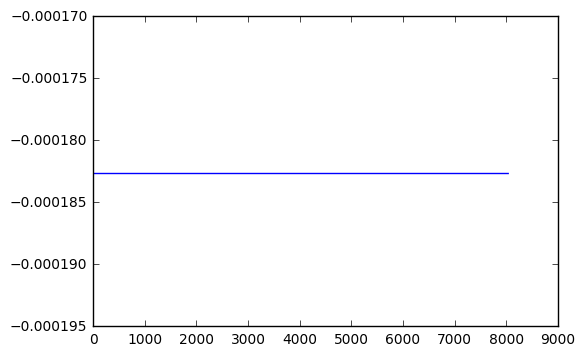

In [39]:
plt.plot(nvidia_model_predictions)

In [34]:
vgg_model_predictions = vgg_model.predict(ordered_track, batch_size=128)

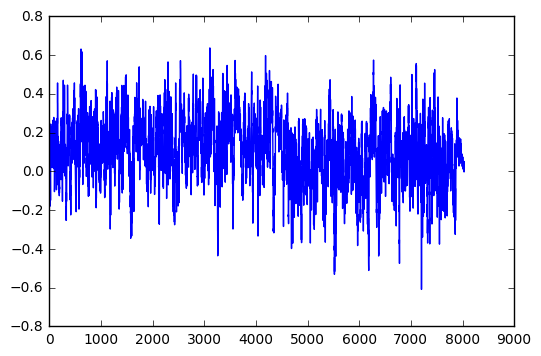

In [35]:
plt.plot(vgg_model_predictions)

Saving the models to the models/unregularized directory

In [40]:
%mkdir "models"
%mkdir "models/unregularized"


In [36]:
unregularized_dir = "models/unregularized/"

model_json = nvidia_model.to_json()
with open(unregularized_dir+"nvidia_model.json", "w") as json_file:
    json_file.write(model_json)

nvidia_model.save_weights(unregularized_dir+"nvidia_model.h5")
print("Saved model to disk")


In [41]:
unregularized_dir = "models/unregularized/"
model_json = vgg_model.to_json()
with open(unregularized_dir+"vgg_model.json", "w") as json_file:
    json_file.write(model_json)

vgg_model.save_weights(unregularized_dir+"vgg_model.h5")
print("Saved model to disk")

Saved model to disk


In [42]:
vgg_features = VGG16(include_top=False, input_shape=(66, 200, 3), weights='imagenet')
vgg_model_2 = Sequential([
        Lambda(lambda x: (x/ 127.5 - 1.),input_shape=(66,200,3)),
    ])
vgg_model_2.add(vgg_features)
for l in vgg_model_2.layers:
    l.trainable = False
vgg_model_2.add(Flatten())
vgg_model_2.add(Dense(100, activation='relu'))
vgg_model_2.add(Dropout(0.5))
vgg_model_2.add(Dense(10, activation='relu'))
vgg_model_2.add(Dropout(0.3))
vgg_model_2.add(Dense(1, activation='tanh'))

vgg_model_2.compile(loss='mse', optimizer=Adam())
vgg_model_2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 66, 200, 3)    0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
vgg16 (Model)                    (None, 2, 6, 512)     14714688    lambda_5[0][0]                   
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 6144)          0           vgg16[1][0]                      
____________________________________________________________________________________________________
dense_17 (Dense)                 (None, 100)           614500      flatten_5[0][0]                  
___________________________________________________________________________________________

In [43]:
batches = train_datagen.flow(X_train, y_train, batch_size=128)
test_batches = train_datagen.flow(X_test, y_test, batch_size=128)
vgg_model_2.fit_generator(batches, batches.N, nb_epoch=5, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/5
36162/36162 [==============================] - 225s - loss: 0.0830 - val_loss: 0.0755
Epoch 2/5
36162/36162 [==============================] - 226s - loss: 0.0609 - val_loss: 0.0600
Epoch 3/5
36162/36162 [==============================] - 226s - loss: 0.0544 - val_loss: 0.0409
Epoch 4/5
36162/36162 [==============================] - 226s - loss: 0.0494 - val_loss: 0.0394
Epoch 5/5
36162/36162 [==============================] - 226s - loss: 0.0482 - val_loss: 0.0391


In [44]:
unregularized_dir = "models/"
model_json = vgg_model_2.to_json()
with open(unregularized_dir+"vgg_model_2.json", "w") as json_file:
    json_file.write(model_json)

vgg_model_2.save_weights(unregularized_dir+"vgg_model_2.h5")
print("Saved model to disk")

Saved model to disk


In [45]:
vgg_model_predictions = vgg_model_2.predict(ordered_track, batch_size=128)

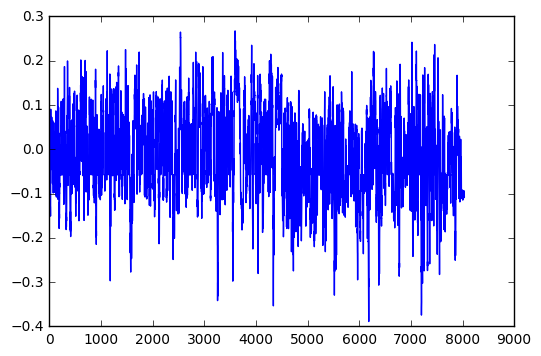

In [46]:
plt.plot(vgg_model_predictions)

Both the models seem to perform too poorly, none of the algorithms seem to be getting taking strong turns, will explore some alternate models in the next iteration